## What is text classification?<a id='what'></a>

Imagine that you work at [YouTube](https://www.youtube.com/) (if you haven't heard of it, YouTube is a video-sharing website). Your job is to remove comments on videos that are spam (unsolicited and inappropriate comments). You look through each video and read the comments yourself, deciding which are spam and which are not spam. Perhaps you see comments like those below. Which would you consider to be spam and which not spam?

- _Hey @dancer317, love ur videos so much! Thanks for all the tips on dancing!_
- _OUR  LASER PRINTER/FAX/COPIER TONER CARTRIDGE PRICES NOW AS LOW AS 39 DOLLARS. SPECIALS WEEKLY ON ALL LASER PRINTER SUPPLIES. WE CARRY MOST ALL LASER PRINTER CARTRIDGES, FAX SUPPLIES AND COPIER TONERS AT WAREHOUSE PRICES_
- _I'm not sold on your first point about crossing national boundaries, but I see what you mean about non-economic alternatives._
- _Some of the most beautiful women in the world bare it all for you. Denise Richards, Britney  Spears, Jessica Simpson, and many more. CLICK HERE FOR NUDE CELEBS_

How did you decide which were spam and which weren't? Maybe one thing you noted was the high number of words in all capitals. The topics can also give you a clue, as the spam-like comments talk about selling things and nudity, which are often found in spam comments.

However you decided, we can think about the task you were doing like this:

<img src='img/human-classification.jpg' />

This is text classification, performed by a human. What you just did was an example of text classification. You took a comment written in English, and you classified it into one of two classes: spam or not spam. Wouldn't it be nice to have a computer do this for you? [You could outsource your job to the computer and just surf the web all day](https://www.npr.org/sections/thetwo-way/2013/01/16/169528579/outsourced-employee-sends-own-job-to-china-surfs-web). What you'd want to do is replace the human with a computer, like this:


<img src='img/computer-classification.jpg' />

How are we going to do this? Well, what if, for each comment on YouTube, we counted the number of times it mentioned nudity or tried to sell something, and we measured the proportion of capital letters? We'd get two numbers for each comment. We could also use your human judgements from before in a third column telling us whether that comment is spam or not.

| Comment                                                 | Selling or nudity | Proportion capital letters | Is it spam? |
|---------------------------------------------------------|-------------------|----------------------------|-------------|
| Hey @dancer317, love ur videos so much! Thanks for ...  | 0                 | 0.1                        | No          |
| OUR LASER PRINTER/FAX/COPIER TONER CARTRIDGE PRICES ... | 4                 | 1.0                        | Yes         |
| I'm not sold on your first point ...                    | 1                 | 0.05                       | No          |
|  Some of the most beautiful women in the world ...      | 3                 | 0.15                       | Yes         |

We can treat these two numbers as geometric coordinates and plot them. We can plot the spam comments in red and the non-spam comments in green.

<img src='img/classification-no-line.jpg' />

<img src='img/classification-with-line.jpg' />

**To do text classification, we're going to need to do two things:**
- **Turn our natural language comments into numbers.**
- **Train a classifier to take those numbers and distinguish between the classes.**

Why do we care about text classification? Because most applied natural language processing problems can be tackled as text classification:

- Sentiment analysis
- Genre classification
- Language identification
- Authorship attribution
- Is this document relevant to this legal case?
- Is the patient in need of urgent care?

### What is sentiment analysis?

In this notebook, we're going to perform [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis) on a dataset of tweets about US airlines. Sentiment analysis is the task of extracting [affective states][1] from text. Sentiment analysis is most ofen used to answer questions like:

[1]: https://en.wikipedia.org/wiki/Affect_(psychology)

- _what do our customers think of us?_
- _do our users like the look of our product?_
- _what aspects of our service are users dissatisfied with?_

### Dataset

The dataset was collected by [Crowdflower](https://www.crowdflower.com/), which they then made public through [Kaggle](https://www.kaggle.com/crowdflower/twitter-airline-sentiment). I've downloaded it for you and put it in the "data" directory. Note that this is a nice clean dataset; not the norm in real-life data science! I've chosen this dataset so that we can concentrate on understanding what text classification is and how to do it.

In [4]:
%matplotlib inline
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
sns.set()

## EDA <a id='eda'></a>

In [22]:
DATA_DIR = 'data'
fname = os.path.join(DATA_DIR, 'tweets.csv')
df = pd.read_csv(fname)
df.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


Which airlines are tweeted about and how many of each in this dataset?

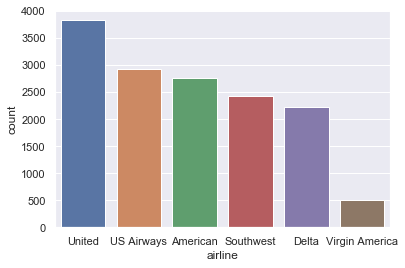

In [6]:
sns.countplot(df['airline'], order=df['airline'].value_counts().index);

### Challenge

- How many tweets are in the dataset?
- How many tweets are positive, neutral and negative?
- What **proportion** of tweets are positive, neutral and negative?
- Visualize these last two questions.

14640
negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64
negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64


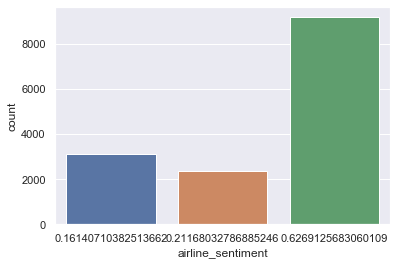

In [19]:
print(len(df))

print(df['airline_sentiment'].value_counts())

print(df['airline_sentiment'].value_counts(normalize=True))

sns.countplot(df['airline_sentiment'])

sns.countplot(df['airline_sentiment'].value_counts(normalize=True))

### Extra challenge

- When did the tweets come from?
- Who gets more retweets: positive, negative or neutral tweets?
- What are the reasons why people tweet negatively? Show distribution.


## Preprocess  <a id='preprocess'></a>

### Regular expressions

Regular expressions are like advanced find-and-replace. They allow us to specify complicated patterns in text data and find all the matches. They are very useful in text processing. You can learn more about them [here](https://github.com/geoffbacon/regular-expressions-in-python).

We can use regular expressions to find hashtags and user mentions in a tweet. We first write the pattern we're looking for as a (raw) string, using regular expression's special syntax. The `twitter_handle_pattern` says "find me a @ sign immediately followed by one or more upper or lower case letters, digits or underscore". The `hashtag_pattern` is a little more complicated; it says "find me exactly one ＃ or #, immediately followed by one or more upper or lower case letters, digits or underscore, but only if it's at the beginning of a line or immediately after a whitespace character".

In [ ]:
import re
twitter_handle_pattern = r'@(\w+)'
hashtag_pattern = r'(?:^|\s)[＃#]{1}(\w+)'
url_pattern = r'https?:\/\/.*.com'
example_tweet = "lol @justinbeiber and @BillGates are like soo #yesterday #amiright saw it on https://twitter.com #yolo"

In [ ]:
re.findall(twitter_handle_pattern, example_tweet)

In [ ]:
re.findall(hashtag_pattern, example_tweet)

In [ ]:
re.findall(url_pattern, example_tweet)

`pandas` has great in-built support for operating with regular expressions on columns. We can `extract` all user mentions from a column of text like this:

In [ ]:
df['text'].str.extract(twitter_handle_pattern).head(10)

And find all the hashtags like this:

In [ ]:
df['text'].str.extract(hashtag_pattern).head(20)

### Challenge

Often in preprocessing text data, we don't care about the exact hashtag/user/URL that someone used (although sometimes we do!). Your job is to replace all the hashtags with `'HASHTAG'`, the user mentions with `'USER'` and URLs with `'URL'`. To do this, you'll use the `replace` string method of the `text` column. The result of this will be a series, which you should add to `df` as a column called `clean_text`. **See the docs [here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.replace.html) for more information on the method.**

# Classification

## Logistic regression with binary class

To understand the theoretical gist of our classification task, let's first focus on a binary 'positive vs negative' classifier. We are going to do so by restricting the analysis to the non-neutral tweets.

In [ ]:
df_bin=df[df['airline_sentiment']!='neutral']
len(df_bin)

### Bag of words and DTM

First, we need to turn the text into numbers for our classifier. We're going to use a "bag of words" as our features. A bag of words is just like a frequency count of all the words that appear in a tweet. It's called a bag because we ignore the order of the words; we just care about what words are in the tweet. To do this, we can use `scikit-learn`'s `CountVectorizer` to build up the document-term matrix (see notebook from day 2).

In [ ]:
countvectorizer = CountVectorizer(max_features=5000, binary=True)
X = countvectorizer.fit_transform(df_bin['clean_text'])
features = X.toarray()
features

In [ ]:
response = df_bin['airline_sentiment'].values
response

### Split into train/test datasets

We don't want to train our classifier on the same dataset that we test it on, so let's split it into training and test sets.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, response, test_size=0.2)
y_train

### Fit a logistic regression model

OK, so now that we've turned our data into numbers, we're ready to feed it into a classifier. More specifically, we are going to fit a logistic regression model where the probability of being positive ($y=1$) is described by a sigmoid function of the form:
$f(X)=P(y=1|X)=\frac{exp(-X'\theta)}{1+exp(-X'\theta)}$. Once $\theta$ - a vector of word _weights_ or _loadings_ - is estimated we can get predict outcomes $\hat{f}$ conditional on observed word count $X$. If $\hat{f}>0.5$ then the observation is classified as positive. This is a _linear classifier_ as the decision boundary is defined by $\frac{exp(-X'\theta)}{1+exp(-X'\theta)}=0.5$, which after reaaranging and taking logs appears equivalent to $-X'\theta=0$ - a linear function of the features $X$.

To those interested in the technicalities, the model is estimated through penalized Maximum Likelihood with cross-validation. (It's always good to know and understand at a high-level what your code is actually doing...)  

We're not going to concentrate too much on the code below, but here's the big picture. In the `fit_model` function defined below, we're going to use the logitistic regression classifier described abover to take in the numerical representation of the tweets and spit out whether it's positive or negative. Then we'll use `test_model` to test the model's performance against our test data and print out some results.

In [ ]:
def fit_logistic_regression(X, y):
    model = LogisticRegressionCV(Cs=5, penalty='l1', cv=3, solver='liblinear', refit=True)
    model.fit(X, y)
    return model

def conmat(model, X, y):
    """Wrapper for sklearn's confusion matrix."""
    labels = model.classes_
    y_pred = model.predict(X)
    c = confusion_matrix(y, y_pred)
    sns.heatmap(c, annot=True, fmt='d', 
                xticklabels=labels, 
                yticklabels=labels, 
                cmap="YlGnBu", cbar=False)
    plt.ylabel('Ground truth')
    plt.xlabel('Prediction')
    
def test_model(model, X, y):
    conmat(model, X_test, y_test)
    print('Accuracy: ', model.score(X_test, y_test))

In [ ]:
lr = fit_logistic_regression(X_train, y_train)

In [ ]:
test_model(lr, X_test, y_test)

### Challenge 1

Fit a _multinomial_ logit model to classify tweets between positive, negative AND neutral.

### Challenge 2

Use the `RandomForestClassifier` imported above to construc a `fit_random_forest` function and train a random forest classifier on the training set. Test the model on the test set. Which performs better?

## More validation

We are going to use the `test_tweet` function below to test your classifier's performance on our own tweets. We can do it using both LR or RF classifiers.

In [ ]:
def clean_tweets(tweets):
    tweets = [re.sub(hashtag_pattern, 'HASHTAG', t) for t in tweets]
    tweets = [re.sub(twitter_handle_pattern, 'USER', t) for t in tweets]
    return [re.sub(url_pattern, 'URL', t) for t in tweets]

def test_tweets(tweets, model):
    tweets = clean_tweets(tweets)
    features = countvectorizer.transform(tweets)
    predictions = model.predict(features)
    return list(zip(tweets, predictions))

In [ ]:
my_tweets = [example_tweet,
            'omg I am never flying on United again',
            'I love @VirginAmerica so much #friendlystaff',
            'food on Air France is great!']

test_tweets(my_tweets, lr)

## Interpret <a id='interpret'></a>

Now we can interpret the classifier by the features that it found important. Let's do it for our preferred logistic regression classifier.

In [ ]:
important = pd.DataFrame(lr.coef_).T
important.columns = lr.classes_
important['word'] = countvectorizer.get_feature_names()
important.head()

In [ ]:
important.sort_values(by='negative', ascending=False).head(10)

In [ ]:
important.sort_values(by='positive', ascending=False).head(10)